## Jupyter notebook for the reproducible generation of test input data

The expected input data to the microsimulation tool in the crime_sim_toolkit is highly similar to police uk data expect also including victim demographic details.

This notebook aims to take standard data from https://data.police.uk/ and randomly allocate victim demographic data in order to represent expected input data. 

In [3]:
import modin.pandas as pds
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# load output area lookup table - from opendata portal

lookup_table = pd.read_csv('http://geoportal1-ons.opendata.arcgis.com/datasets/fe6c55f0924b4734adf1cf7104a0173e_0.csv')

In [5]:
# function for loading monthly police data csvs

def load_police_csv(year=2017, engine="pandas"):
    
    if engine == "pandas":
        
        prefix = pd
    
    elif engine == "modin":
        
        prefix = pds
    
    file_list = glob.glob('../scrapbook/data/pol_dat/*')
    
    year_str = str(year)
    
    selected_files = [file for file in file_list if year_str in file]
    
    print('Number of files found: ',len(selected_files))
    
    files_combo = []
    
    for file in selected_files:

            open_file = prefix.read_csv(file)

            files_combo.append(open_file)

    combined_files = prefix.concat(files_combo, axis=0)

    combined_files.reset_index(inplace=True, drop=True)
    
    return combined_files

In [6]:
pol_dat_2017 = load_police_csv(year=2017, engine="pandas")

Number of files found:  12


In [7]:
pol_dat_2017.shape

(320006, 12)

In [8]:
pol_dat_2017 = pol_dat_2017.drop('Context', axis=1).dropna()

pol_dat_2017.reset_index(drop=True, inplace=True)

In [9]:
pol_dat_2017.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category
0,ed5e6cc15caffcd1d1993d57dd12bd3b5462db330fc3c2...,2017-10,West Yorkshire Police,West Yorkshire Police,-1.764583,53.534617,On or near Park/Open Space,E01007426,Barnsley 027D,Burglary,Investigation complete; no suspect identified
1,eae51159cf301b4fc5fe8350d4b89212455b448388e6a7...,2017-10,West Yorkshire Police,West Yorkshire Police,-1.863065,53.939035,On or near Low Mill,E01010646,Bradford 001A,Burglary,Status update unavailable
2,5e22e40d676365342bb7de2869639bb05d8265316abc21...,2017-10,West Yorkshire Police,West Yorkshire Police,-1.876367,53.942950,On or near Croft House Fold,E01010646,Bradford 001A,Violence and sexual offences,Unable to prosecute suspect
3,48a8de992ba49e0e1c3c87c5da641b538079e0f2478bb8...,2017-10,West Yorkshire Police,West Yorkshire Police,-1.882481,53.924936,On or near Moorside Lane,E01010646,Bradford 001A,Violence and sexual offences,Unable to prosecute suspect
4,35f45581ef68c665f5b2c892ec6efcae0d482b6ee3e1b1...,2017-10,West Yorkshire Police,West Yorkshire Police,-1.876367,53.942950,On or near Croft House Fold,E01010646,Bradford 001A,Violence and sexual offences,Action to be taken by another organisation


In [10]:
pol_dat_2017.shape

(245012, 11)

In [11]:
pol_dat_2017['LSOA11CD'] = pol_dat_2017['LSOA code']

pol_dat_2017.drop('LSOA code', axis=1, inplace=True)

In [12]:
pol_dat_2017 = pd.merge(pol_dat_2017, lookup_table[['LSOA11CD','MSOA11CD']], on='LSOA11CD', how='inner').drop_duplicates()

pol_dat_2017.reset_index(drop=True, inplace=True)

In [13]:
## transform synthetic population into full population table for west yorkshire or MSOA level

pop_2017 = pd.read_csv('../scrapbook/data/LeedsLADdata/ssm_E08000035_MSOA11_ppp_2017.csv')

In [14]:
# function for loading monthly police data csvs

def load_pop(year=2017, engine="pandas"):
    
    if engine == "pandas":
        
        prefix = pd
    
    elif engine == "modin":
        
        prefix = pds
    
    file_list = glob.glob('../scrapbook/data/WYP_spenser_data/*')
    
    year_str = str(year)
    
    selected_files = [file for file in file_list if year_str in file]
    
    print('Number of files found: ',len(selected_files))
    
    files_combo = []
    
    for file in selected_files:

            open_file = prefix.read_csv(file)

            files_combo.append(open_file)

    combined_files = prefix.concat(files_combo, axis=0)

    combined_files.reset_index(inplace=True, drop=True)
    
    return combined_files

In [15]:
pop_2017 = load_pop()

Number of files found:  5


In [16]:
pop_2017['multi_cat_col'] = pop_2017.DC1117EW_C_SEX.astype(str) + '-' + pop_2017.DC1117EW_C_AGE.astype(str) + '-' + pop_2017.DC2101EW_C_ETHPUK11.astype(str)

In [17]:
pop_2017['multi_cat_col'].value_counts()

2-86-2    26113
2-47-2    13437
1-47-2    13339
1-86-2    13295
2-48-2    13137
          ...  
2-69-4        2
2-80-4        1
1-79-4        1
1-83-4        1
1-78-4        1
Name: multi_cat_col, Length: 3095, dtype: int64

In [18]:
pop_2017['multi_cat_col'].value_counts().sum()

2302328

In [19]:
# get a series of proportions of demographic groups
demographic_prop = pop_2017['multi_cat_col'].value_counts() / pop_2017['multi_cat_col'].value_counts().sum()

In [20]:
demographic_prop.values

array([1.13419982e-02, 5.83626660e-03, 5.79370098e-03, ...,
       4.34342978e-07, 4.34342978e-07, 4.34342978e-07])

In [21]:
# random choice using proportions 
np.random.choice(demographic_prop.index, p=demographic_prop.values)

'1-57-2'

In [22]:
pol_dat_2017['victim_profile'] = pol_dat_2017.apply(lambda x: np.random.choice(demographic_prop.index, p=demographic_prop.values), axis=1)

In [23]:
# get proportions of populations and check they approximately match

generated_demo_prop = pol_dat_2017['victim_profile'].value_counts() / pol_dat_2017['victim_profile'].value_counts().sum()

actual_demo_prop = pop_2017['multi_cat_col'].value_counts() / pop_2017['multi_cat_col'].value_counts().sum()


of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



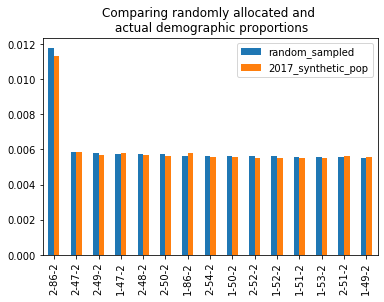

In [24]:
counts_compare = pd.concat([generated_demo_prop, actual_demo_prop], axis=1)

counts_compare.columns = ['random_sampled','2017_synthetic_pop']

counts_compare.sort_values(by=['random_sampled','2017_synthetic_pop'], ascending=False)[:15].plot.bar()

plt.title('Comparing randomly allocated and \n actual demographic proportions')

plt.savefig('outputs/random_victim_profiles_top10.png', format='png', bbox_inches='tight')

In [25]:
pol_dat_2017.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA name,Crime type,Last outcome category,LSOA11CD,MSOA11CD,victim_profile
0,ed5e6cc15caffcd1d1993d57dd12bd3b5462db330fc3c2...,2017-10,West Yorkshire Police,West Yorkshire Police,-1.764583,53.534617,On or near Park/Open Space,Barnsley 027D,Burglary,Investigation complete; no suspect identified,E01007426,E02001535,2-66-2
1,3d074ff1d8ea40781b1eae18dcda27e94c33cca0da31df...,2017-03,West Yorkshire Police,West Yorkshire Police,-1.670108,53.553629,On or near Huddersfield Road,Barnsley 027D,Other theft,Investigation complete; no suspect identified,E01007426,E02001535,1-44-2
2,e214a5b554799a92b2e95512274001928bceb1d677b1cf...,2017-03,West Yorkshire Police,West Yorkshire Police,-1.724364,53.557200,On or near Hey Slack Lane,Barnsley 027D,Other theft,Investigation complete; no suspect identified,E01007426,E02001535,1-18-2
3,dc49a93f22f277264513f4bd9861b273ae99a571e7909d...,2017-07,West Yorkshire Police,West Yorkshire Police,-1.706334,53.549364,On or near Brown'S Edge Road,Barnsley 027D,Burglary,Investigation complete; no suspect identified,E01007426,E02001535,2-86-2
4,e3f824bdf749192c3fdcc80d3099b03bc8d8d9436a9c1c...,2017-07,West Yorkshire Police,West Yorkshire Police,-1.670108,53.553629,On or near Huddersfield Road,Barnsley 027D,Theft from the person,Investigation complete; no suspect identified,E01007426,E02001535,1-47-2


In [26]:
# we'll assume victim profile is separated in data frame so will separate this combined values

expanded_demo = pol_dat_2017['victim_profile'].str.split('-', expand=True)

expanded_demo.columns = ['sex','age','ethnicity']

pol_dat_2017 = pd.concat([pol_dat_2017, expanded_demo], axis=1)

In [27]:
pol_dat_2017.columns

pol_dat_2017.columns = ['Crime_ID', 'Month', 'Reported_by', 'Falls_within', 'Longitude',
       'Latitude', 'Location', 'LSOA_name', 'Crime_type',
       'Last_outcome_category', 'LSOA_code', 'MSOA11CD', 'victim_profile',
       'sex', 'age', 'ethnicity']

In [28]:
# add in function to add more specific crime types
import pandas as pd
import numpy as np
import pkg_resources

resource_package = 'crime_sim_toolkit'


def populate_offence(crime_frame):
    """
    Function for adding in more specific offense descriptions based on Police
    Recorded Crime Data tables.

    Profiled run on test data:
    # ver2
    CPU times: user 2min 19s, sys: 2.09 s, total: 2min 21s
    Wall time: 2min 21s
    """

    # format columns to remove spaces
    crime_frame.columns = crime_frame.columns.str.replace(' ','_')

    # initially load reference tables
    LSOA_pf_reference = pd.read_csv(pkg_resources.resource_filename(resource_package, 'src/LSOA_data/PoliceforceLSOA.csv'),
                                    index_col=0)

    descriptions_reference = pd.read_csv(pkg_resources.resource_filename(resource_package, 'src/prc-pfa-201718_new.csv'),
                             index_col=0)

    # test if the first instance in LSOA code is within police force frame?
    # if value is not in the list of police forces from reference frame
    # add police force column
    if crime_frame['LSOA_code'].unique().tolist()[0] not in LSOA_pf_reference.Police_force.tolist():

        crime_frame['Police_force'] = crime_frame.LSOA_code.map(lambda x: LSOA_pf_reference[LSOA_pf_reference['LSOA Code'].isin([x])].Police_force.tolist()[0])

    # else convert LSOA_code to Police_force column
    else:

        crime_frame['Police_force'] = crime_frame['LSOA_code']

    list_of_slices = []

    # for each police force within the passed crime reports data frame
    for police_force in crime_frame.Police_force.unique():

        # slice a frame for data in a specific police force
        shortened_frame = crime_frame[crime_frame['Police_force'] == police_force].copy()

        # create sliced frame of crime description proportions by police force
        descriptions_slice = descriptions_reference[descriptions_reference['Force_Name'].isin([police_force])]

        # create pivot table for random allocating weighting
        # this creates a table of offence description percentages for each Policeuk_Cat
        pivoted_slice = ((descriptions_slice.groupby(['Policeuk_Cat','Offence_Group','Offence_Description'])['Number_of_Offences'].sum() \
        / descriptions_slice.groupby(['Policeuk_Cat'])['Number_of_Offences'].sum())).reset_index()

        # add a Crime_description column that is generated by taking each Crime_type (Policeuk_cat)
        # and using np.random.choice to randomly allocate a Crime description for the given Crime_type
        # weighted by the percentages in the pivot table created above
        shortened_frame['Crime_description'] = shortened_frame['Crime_type'].map(lambda x: np.random.choice(
                                                                                 # specify list of choices of crime_descriptions for given crime_cat
                                                                                 pivoted_slice[pivoted_slice.Policeuk_Cat.str.lower().isin([x.lower()])].Offence_Description.tolist(),
                                                                                 # make one choice
                                                                                 1,
                                                                                 # specify weights for selecting Crime_description
                                                                                 # if there isn't a match between two dataframes (for anti-social behaviour)
                                                                                 # just use Crime_type as Crime Description
                                                                                 # outcome: all Anti-social behaviour cases have that as crime description
                                                                                 p = pivoted_slice[pivoted_slice.Policeuk_Cat.str.lower().isin([x.lower()])].Number_of_Offences.tolist())[0] if len(pivoted_slice[pivoted_slice.Policeuk_Cat.str.lower().isin([x.lower()])]) > 0 else x)

        shortened_frame.Crime_description = shortened_frame.Crime_description.str.lower()

        list_of_slices.append(shortened_frame)

    populated_frame = pd.concat(list_of_slices)


    return populated_frame

In [29]:
pol_dat_2017 = populate_offence(pol_dat_2017)

In [30]:
pol_dat_2017.head()

,Crime_ID,Month,Reported_by,Falls_within,Longitude,Latitude,Location,LSOA_name,Crime_type,Last_outcome_category,LSOA_code,MSOA11CD,victim_profile,sex,age,ethnicity,Police_force,Crime_description
0,ed5e6cc15caffcd1d1993d57dd12bd3b5462db330fc3c2...,2017-10,West Yorkshire Police,West Yorkshire Police,-1.764583,53.534617,On or near Park/Open Space,Barnsley 027D,Burglary,Investigation complete; no suspect identified,E01007426,E02001535,2-66-2,2,66,2,South Yorkshire,burglary business and community
1,3d074ff1d8ea40781b1eae18dcda27e94c33cca0da31df...,2017-03,West Yorkshire Police,West Yorkshire Police,-1.670108,53.553629,On or near Huddersfield Road,Barnsley 027D,Other theft,Investigation complete; no suspect identified,E01007426,E02001535,1-44-2,1,44,2,South Yorkshire,other theft
2,e214a5b554799a92b2e95512274001928bceb1d677b1cf...,2017-03,West Yorkshire Police,West Yorkshire Police,-1.724364,53.557200,On or near Hey Slack Lane,Barnsley 027D,Other theft,Investigation complete; no suspect identified,E01007426,E02001535,1-18-2,1,18,2,South Yorkshire,other theft
3,dc49a93f22f277264513f4bd9861b273ae99a571e7909d...,2017-07,West Yorkshire Police,West Yorkshire Police,-1.706334,53.549364,On or near Brown'S Edge Road,Barnsley 027D,Burglary,Investigation complete; no suspect identified,E01007426,E02001535,2-86-2,2,86,2,South Yorkshire,attempted burglary residential
4,e3f824bdf749192c3fdcc80d3099b03bc8d8d9436a9c1c...,2017-07,West Yorkshire Police,West Yorkshire Police,-1.670108,53.553629,On or near Huddersfield Road,Barnsley 027D,Theft from the person,Investigation complete; no suspect identified,E01007426,E02001535,1-47-2,1,47,2,South Yorkshire,theft from the person


In [31]:
# randomly sample from 2017 dataset to give 5% of it for testing
pol_dat_2017.sample(frac=0.01).to_csv('../crime_sim_toolkit/tests/testing_data/test_microsim/sample_vic_data_WY2017.csv', index=None)

In [32]:
# save this file out as a .csv 

pol_dat_2017.to_csv('data/2017_WY_crimes_victimdemo.csv', index=None)